# Trabajo Práctico 2: Análisis con Boosting - Organización de Datos

**Alumnos y Padrón**  
* Grassano, Bruno - 103855  
* Romero, Adrián   - 103371

https://github.com/brunograssano/TP-Organizacion-de-datos

## Importamos las bibiliotecas necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
from preprocessing import prepararSetDeDatos
from preprocessing import prepararSetDeHoldout
from preprocessing import expansionDelDataset
from preprocessing import prepararSetDeValidacion
from preprocessing import conversionAVariablesNumericas

In [5]:
from funcionesAuxiliares import mostrarAUCScore
from funcionesAuxiliares import mostrarROCCurve
from funcionesAuxiliares import mostrarMatrizDeConfusion
from funcionesAuxiliares import escribirPrediccionesAArchivo
from funcionesAuxiliares import obtenerDatasets
from funcionesAuxiliares import obtenerHoldout

## Importamos los datos y los procesamos

Leemos los datos que tenemos y llamamos a las funciones que se encargarán de dejar listos los datasets con la investigación del TP1.

In [6]:
X, y = obtenerDatasets()
X = prepararSetDeDatos(X)
y = prepararSetDeValidacion(y)

In [7]:
nombres_de_features, X_b = conversionAVariablesNumericas(X)

## Funciones Auxiliares

In [8]:
def obtenerMejoresParametros(datosPreprocesados):
    mejor_valor = 0
    mejor_fc_perdida = None
    mejor_lr = None
    mejor_cantidad_estimadores = None
    mejor_criterio = None
    y_array=np.array(y)
    for fc_perdida in ["deviance", "exponential"]:
        for lr in [0.1, 0.01, 0.001]:
            for cantidad_estimadores in [10, 50, 100, 150]:
                for criterio in ["friedman_mse", "mse", "mae"]:
                    kf = StratifiedKFold(n_splits=5)
                    metricas = []
                    for fold_idx, (train_index, test_index) in enumerate(kf.split(datosPreprocesados, y_array)):
                        b = GradientBoostingClassifier(criterion=criterio, loss=fc_perdida, n_estimators=cantidad_estimadores, learning_rate=lr)
                        b.fit(datosPreprocesados[train_index], y_array[train_index].ravel())
                        predicciones = b.predict(datosPreprocesados[test_index])
                        score_obtenida = roc_auc_score(y_array[test_index],predicciones)
                        metricas.append(score_obtenida)

                    if np.mean(metricas) >= mejor_valor:
                        mejor_valor = np.mean(metricas)
                        mejor_fc_perdida = fc_perdida
                        mejor_lr = lr
                        mejor_cantidad_estimadores = cantidad_estimadores
                        mejor_criterio = criterio
            
    return mejor_valor, mejor_fc_perdida, mejor_lr, mejor_cantidad_estimadores, mejor_criterio

# Boosting

En boosting se entrena un primer modelo sobre todo el set de entrenamiento. Luego se entrenan modelos subsiguientes a partir de los datos que el modelo anterior predijo mal. De esta forma la varianza total del ensamble es baja, porque cada modelo entrenado ponderará de forma distinta las observaciones. En general los ensambles tienen bajo sesgo, y en particular boosting logra bajar la varianza. 

A cada instancia se le asigna inicialmente un peso, luego se predice y se recalculan los pesos, restandole importancia a las bien clasificadas para entrenar al modelo siguiente.

Los parametros a definir en Boosting son:

**Loss:** la función de pérdida que se busca optimizar

**Learning rate:** es la tasa de aprendizaje con la que se busca optimizar la función de pérdida anterior.

**Número de estimadores:** es la cantidad de estimadores con los que se entrenará

Nuevamente construiremos dos modelos, uno utilizando el dataset expandido y el otro no.

### Dividimos el set de datos en sets de training y test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size=0.25, random_state=0)

###### Para  el dataset expandido:

In [10]:
X_expandido = expansionDelDataset(X)

columnas_codificables_extra = ['pago_categorizado','edades_estratificadas','categoria_invitados']
columnas_numericas_extra = ['4_clusters','10_clusters','total_pagado']

nombre_de_los_features_expandidos, X_exp  = conversionAVariablesNumericas(X_expandido,columnas_codificables_extra,columnas_numericas_extra)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

### Buscamos los mejores parámetros

In [11]:
mejor_valor, mejor_fc_perdida, mejor_lr, mejor_cantidad_estimadores, mejor_criterio = obtenerMejoresParametros(X_b)

In [ ]:
print(f"El mejor valor fue de AUC fue: {mejor_valor.round(3)}")
print(f"La mejor funcion de perdida encontrada que maximiza el AUC fue: {mejor_fc_perdida}")
print(f"El mejor learning rate encontrado que maximiza el AUC fue: {mejor_lr}")
print(f"La mejor cantidad de estimadores que maximiza el AUC fue: {mejor_cantidad_estimadores}")
print(f"El mejor criterio encontrado que maximiza el AUC fue: {mejor_criterio}")

###### Utilizando  el dataset expandido:

In [13]:
mejor_valor_exp, mejor_fc_perdida_exp, mejor_lr_exp, mejor_cantidad_estimadores_exp, mejor_criterio_exp = obtenerMejoresParametros(X_exp)

In [14]:
print(f"El mejor valor fue de AUC fue: {mejor_valor_exp.round(3)}")
print(f"La mejor funcion de perdida encontrada que maximiza el AUC fue: {mejor_fc_perdida_exp}")
print(f"El mejor learning rate encontrado que maximiza el AUC fue: {mejor_lr_exp}")
print(f"La mejor cantidad de estimadores que maximiza el AUC fue: {mejor_cantidad_estimadores_exp}")
print(f"El mejor criterio encontrado que maximiza el AUC fue: {mejor_criterio_exp}")

El mejor valor fue de AUC fue: 0.8096452824034601
La mejor funcion de perdida encontrada que maximiza el AUC fue: deviance
El mejor learning rate encontrado que maximiza el AUC fue: 0.1
La mejor cantidad de estimadores que maximiza el AUC fue: 100
El mejor criterio encontrado que maximiza el AUC fue: mse


### Evaluamos las métricas

In [15]:
boosting = GradientBoostingClassifier(loss=mejor_fc_perdida, learning_rate=mejor_lr, n_estimators=mejor_cantidad_estimadores, criterion=mejor_criterio)
boosting.fit(X_train, y_train)

              precision    recall  f1-score   support

   No vuelve       0.83      0.93      0.88       121
      Vuelve       0.88      0.71      0.79        80

    accuracy                           0.85       201
   macro avg       0.85      0.82      0.83       201
weighted avg       0.85      0.85      0.84       201



In [21]:
y_pred = boosting.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=['No vuelve','Vuelve']))

###### Utilizando  el dataset expandido:

In [16]:
boosting_exp = GradientBoostingClassifier(loss=mejor_fc_perdida_exp, learning_rate=mejor_lr_exp, n_estimators=mejor_cantidad_estimadores_exp, criterion=mejor_criterio_exp)
boosting_exp.fit(X_exp_train, y_exp_train)

ValueError: Number of features of the model must match the input. Model n_features is 14 and input n_features is 24 

In [23]:
y_exp_pred = boosting_exp.predict(X_exp_test)

In [24]:
print(classification_report(y_exp_test, y_exp_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.82      0.90      0.86       121
      Vuelve       0.82      0.70      0.76        80

    accuracy                           0.82       201
   macro avg       0.82      0.80      0.81       201
weighted avg       0.82      0.82      0.82       201



### Matriz de confusión

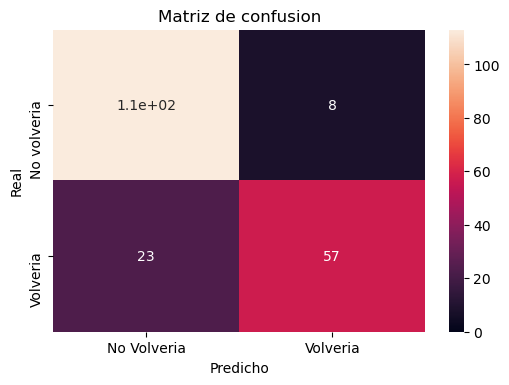

In [25]:
mostrarMatrizDeConfusion(y_pred, y_test)

De la matriz podemos ver que tenemos pocos falsos negativos, tan solo 8 y por lo tanto tenemos un muy buen precision.

###### Utilizando  el dataset expandido:

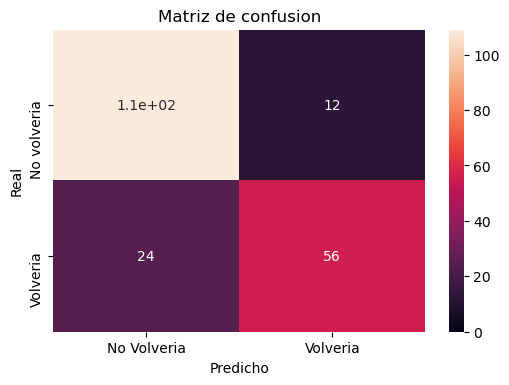

In [26]:
mostrarMatrizDeConfusion(y_exp_pred, y_exp_test)

### Graficamos la curva ROC

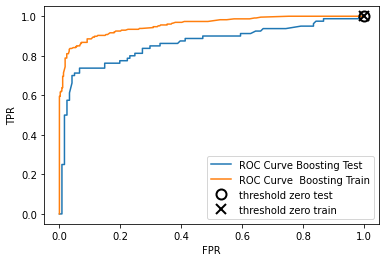

In [27]:
mostrarROCCurve(boosting,"Boosting",X_test, X_train, y_test, y_train)

In [28]:
mostrarAUCScore(boosting,"Boosting",X_test,y_test)

AUC para Boosting: 0.862


###### Utilizando  el dataset expandido:

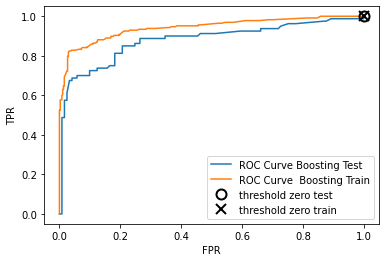

In [29]:
mostrarROCCurve(boosting_exp,"Boosting",X_exp_test, X_exp_train, y_exp_test, y_exp_train)

In [30]:
mostrarAUCScore(boosting_exp,"Boosting",X_exp_test,y_exp_test)

AUC para Boosting: 0.878


## Predicciones sobre el nuevo archivo

Obtenemos y preparamos el nuevo archivo realizando el mismo preprocesamiento realizado anteriormente.

Dado que obtuvimos mejores resultados utilizando el boosting que utiliza el dataset expandido, será este el que utilizaremos para predecir sobre holdout.

In [31]:
holdout = obtenerHoldout()
holdout = prepararSetDeHoldout(holdout)

In [35]:
nombres_de_las_variables, holdout_boosting = conversionAVariablesNumericas(holdout)

holdout_expandido = expansionDelDataset(holdout)
nombre_de_los_features_expandidos, holdout_boosting_expandido  = conversionAVariablesNumericas(holdout_expandido,columnas_codificables_extra,columnas_numericas_extra)

In [33]:
predicciones_holdout = boosting_exp.predict(holdout_boosting_expandi)

ValueError: Number of features of the model must match the input. Model n_features is 24 and input n_features is 14 

In [ ]:
escribirPrediccionesAArchivo(predicciones_holdout,"Boosting")